# Directory Setup & Imports

In [0]:
import os
os.chdir("/content/drive/My Drive/Datasets")

In [0]:
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing Steps

### Create vocabulary of words & slots from Training Data

In [0]:
vocab = {"<PAD>": 0, "BOS": 1, "EOS": 2, "<unk>": 3}
vocab_size = 4

slots = {"<PAD>": 0, "BOS": 1, "EOS": 2, "<unk>": 3}
slots_size = 4

# Add BOS & EOS markers to sentences
def addSentenceMarkers(lines):
    new_lines = []
    for line in lines:
        new_lines.append("BOS " + line + " EOS")
    return new_lines

# Prepare the Vocabulary based on the sentences provided
def prepVocab(lines):
    for line in lines:
        for word in line.split():
            if word not in vocab:
                global vocab_size
                vocab[word] = vocab_size
                vocab_size += 1

# Prepare the Slots Vocabulary based on the sentences provided
def prepSlots(lines):
    for line in lines:
        for word in line.split():
            if word not in slots:
                global slots_size
                slots[word] = slots_size
                slots_size += 1

# Convert input sentences to vocabulary indices
def indexFromSentence(lines):
    sent_indices = []
    for line in lines:
        word_indices = []
        for word in line.split():
            try:
                word_indices.append(vocab[word])
            except KeyError as e:
                word_indices.append(vocab["<unk>"])
        sent_indices.append(word_indices)
    return sent_indices

# Convert output sentences to slot indices
def indexFromSlots(lines):
    sent_indices = []
    for line in lines:
        word_indices = []
        for word in line.split():
            try:
                word_indices.append(slots[word])
            except KeyError as e:
                word_indices.append(slots["<unk>"])
        sent_indices.append(word_indices)
    return sent_indices

# Load the training dataset
def loadTrainData(seq_in_path, seq_out_path):
    with open(seq_in_path, "r") as file:
        input_sent = file.readlines()
    input_sent = addSentenceMarkers(input_sent)
    prepVocab(input_sent)

    with open(seq_out_path, "r") as file:
        output_slots = file.readlines()
    output_slots = addSentenceMarkers(output_slots)
    prepSlots(output_slots)

    sent_indices = indexFromSentence(input_sent)
    slot_indices = indexFromSlots(output_slots)

    df = pd.DataFrame({"sentence": sent_indices, "slots": slot_indices})
    return df

In [0]:
train_df = loadTrainData("snips/train/seq.in", "snips/train/seq.out")

In [5]:
train_df.head()

,sentence,slots
0,"[1, 4, 5, 6, 7, 8, 9, 10, 11, 2]","[1, 4, 4, 5, 4, 6, 4, 7, 8, 2]"
1,"[1, 12, 13, 5, 14, 5, 15, 16, 17, 18, 2]","[1, 4, 9, 10, 10, 4, 4, 11, 12, 4, 2]"
2,"[1, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29...","[1, 4, 4, 4, 13, 14, 4, 4, 4, 4, 15, 4, 4, 4, ..."
3,"[1, 32, 15, 33, 34, 35, 36, 2]","[1, 4, 4, 17, 18, 19, 19, 2]"
4,"[1, 37, 12, 38, 39, 5, 40, 18, 21, 41, 42, 2]","[1, 4, 4, 5, 20, 4, 21, 4, 11, 12, 12, 2]"


In [6]:
print("Vocabulary Size: ", vocab_size)
print("Types of Slots: ", slots_size)
print("Number of training examples: ", len(train_df))

Vocabulary Size:  11422
Types of Slots:  76
Number of training examples:  13084


In [0]:
# Store reverse mappings from indices to words in vocabulary & slots (needed during evaluation)

indices_to_words = {v:k for k,v in vocab.items()}
indices_to_slots = {v:k for k,v in slots.items()}

In [0]:
# Load the validation dataset
def loadValidData(seq_in_path, seq_out_path):
    with open(seq_in_path, "r") as file:
        input_sent = file.readlines()
    input_sent = addSentenceMarkers(input_sent)

    with open(seq_out_path, "r") as file:
        output_slots = file.readlines()
    output_slots = addSentenceMarkers(output_slots)

    sent_indices = indexFromSentence(input_sent)
    slot_indices = indexFromSlots(output_slots)

    df = pd.DataFrame({"sentence": sent_indices, "slots": slot_indices})
    return df

In [9]:
valid_df = loadValidData("snips/valid/seq.in", "snips/valid/seq.out")
valid_df.head()

,sentence,slots
0,"[1, 19, 162, 163, 5, 1002, 21, 139, 299, 40, 4...","[1, 4, 4, 4, 4, 4, 4, 17, 4, 21, 11, 12, 4, 2]"
1,"[1, 12, 15, 210, 5, 40, 604, 256, 18, 2]","[1, 4, 4, 17, 4, 21, 11, 12, 4, 2]"
2,"[1, 12, 3890, 70, 5, 40, 211, 110, 1673, 18, 2]","[1, 4, 11, 12, 4, 21, 9, 10, 10, 4, 2]"
3,"[1, 12, 21, 33, 51, 844, 3, 5, 40, 855, 2531, ...","[1, 4, 4, 17, 4, 5, 20, 4, 21, 11, 12, 4, 2]"
4,"[1, 12, 21, 210, 5, 510, 511, 1638, 512, 2]","[1, 4, 4, 17, 4, 11, 12, 12, 12, 2]"


### Create custom Dataset & Dataloader

In [0]:
# Custom class to hande the Snips Dataset
class SnipsDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data.iloc[i]["sentence"], self.data.iloc[i]["slots"]

In [0]:
# Function to combine a batch of variable length sentence-slot pairs & pad them appropriately to train using an RNN
def pad_collate(batch):
    (xx, yy) = zip(*batch)

    x_lens = torch.tensor([len(x) for x in xx], dtype=torch.int64, device=device)
    y_lens = torch.tensor([len(y) for y in yy], dtype=torch.int64, device=device)

    longest_sent = max(x_lens)
    batch_size  = len(xx)


    xx_pad = torch.ones((batch_size, longest_sent), dtype=torch.int64, device=device) * 0
    yy_pad = torch.ones((batch_size, longest_sent), dtype=torch.int64, device=device) * 0

    for i, x_len in enumerate(x_lens):
        xx_pad[i, 0:x_len] = torch.tensor(xx[i][:x_len])
        yy_pad[i, 0:x_len] = torch.tensor(yy[i][:x_len])

    return xx_pad, yy_pad, x_lens, y_lens

# Model for Semantic Slot Filling

In [0]:
class SlotFillingNetwork(nn.Module):
    def __init__(self, vocab_size, slots_size, embedding_size, hidden_size):
        super(SlotFillingNetwork, self).__init__()

        self.vocab_size = vocab_size
        self.slots_size = slots_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(self.vocab_size, embedding_size)
        
        # Bidirectional GRU
        self.gru = nn.GRU(embedding_size, self.hidden_size, num_layers = 1, batch_first = True, bidirectional =True)

        self.dense = nn.Linear(2*self.hidden_size, self.slots_size)

    def forward(self, input, input_lens, hidden):
        embedded = self.embedding(input)

        # Pack the padded, embedded sequences before passing through the GRU
        sentences_packed = pack_padded_sequence(embedded, input_lens, batch_first=True, enforce_sorted=False)
        
        output_packed, hidden = self.gru(sentences_packed, hidden)

        # Return the padded output format
        output_padded, output_lengths = pad_packed_sequence(output_packed, batch_first=True)

        output_padded = self.dense(output_padded)

        return output_padded, hidden

    def initHidden(self, batch_size):
        return torch.zeros(2, batch_size, self.hidden_size, device=device) # 1st argument = 2 to indicate the bidirectional nature of GRU

In [13]:
# Create the SlotFillingNetwork Model
slot_filling_net = SlotFillingNetwork(vocab_size, slots_size, embedding_size = 100, hidden_size = 100).to(device)
print(slot_filling_net)

SlotFillingNetwork(
  (embedding): Embedding(11422, 100)
  (gru): GRU(100, 100, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=200, out_features=76, bias=True)
)


# Training of the Model

### Define the Loss Function & Optimizer

In [0]:
optimizer = optim.Adagrad(slot_filling_net.parameters(), lr = 0.01)
CELoss = nn.CrossEntropyLoss(ignore_index = slots["<PAD>"])

### Create the function for training the model

In [0]:
def train(batch_size=64, num_epochs=50, print_every=None):
    train_dataset = SnipsDataset(train_df)
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, collate_fn=pad_collate)

    valid_dataset = SnipsDataset(valid_df)
    valid_data_loader = DataLoader(dataset=valid_dataset, batch_size=len(valid_dataset), collate_fn=pad_collate)

    train_loss = []
    train_iter = []
    valid_loss = []
    valid_iter = []

    iter = 0

    for epoch in range(num_epochs):
        tot_epoch_loss = 0
        for i, (batch_sent, batch_slot, batch_sent_lens, batch_slot_lens) in enumerate(train_data_loader):
            hidden = slot_filling_net.initHidden(batch_size)
            iter += 1
            slot_predicted_padded, hidden = slot_filling_net.forward(batch_sent, batch_sent_lens, hidden)
            
            batch_loss = CELoss(slot_predicted_padded.view(-1, slots_size), batch_slot.view(-1))
            tot_epoch_loss += batch_loss.item() * len(batch_sent)
            train_loss.append(batch_loss)
            train_iter.append(iter)
            
            if print_every and ((i+1) % print_every == 0 or i == 0):
                # Once a while, run the model on the validation dataset (as a batch) to check validation loss
                with torch.no_grad():
                    valid_hidden = slot_filling_net.initHidden(len(valid_dataset))
                    for valid_batch_sent, valid_batch_slot, valid_batch_sent_lens, valid_batch_slot_lens in valid_data_loader:
                        valid_slot_predicted_padded, valid_hidden = slot_filling_net.forward(valid_batch_sent, valid_batch_sent_lens, valid_hidden)
                        valid_batch_loss = CELoss(valid_slot_predicted_padded.view(-1, slots_size), valid_batch_slot.view(-1))
                        valid_loss.append(valid_batch_loss)
                        valid_iter.append(iter)

                print("[Epoch: %d\tBatch: %d]\tTraining Loss: %.4f\tValidation Loss: %.4f" % (epoch+1, i+1, batch_loss.item(), valid_batch_loss.item()))
            
            batch_loss.backward(retain_graph=True)
            optimizer.step()
        
        avg_epoch_loss = tot_epoch_loss / len(train_dataset.data)
        print("[Epoch: %d]\tTraining Loss: %.4f\n" % (epoch+1, avg_epoch_loss))
    
    return train_loss, train_iter, valid_loss, valid_iter


### Actual training & Plotting of Loss vs Iterations

[Epoch: 1	Batch: 1]	Training Loss: 4.3844	Validation Loss: 4.3936
[Epoch: 1	Batch: 50]	Training Loss: 0.5496	Validation Loss: 0.5762
[Epoch: 1	Batch: 100]	Training Loss: 0.4010	Validation Loss: 0.3861
[Epoch: 1	Batch: 150]	Training Loss: 0.3167	Validation Loss: 0.3159
[Epoch: 1	Batch: 200]	Training Loss: 0.3754	Validation Loss: 0.2864
[Epoch: 1]	Training Loss: 0.5566

[Epoch: 2	Batch: 1]	Training Loss: 0.2552	Validation Loss: 0.2859
[Epoch: 2	Batch: 50]	Training Loss: 0.1544	Validation Loss: 0.2917
[Epoch: 2	Batch: 100]	Training Loss: 0.1473	Validation Loss: 0.2780
[Epoch: 2	Batch: 150]	Training Loss: 0.1076	Validation Loss: 0.2849
[Epoch: 2	Batch: 200]	Training Loss: 0.1715	Validation Loss: 0.2902
[Epoch: 2]	Training Loss: 0.1514

[Epoch: 3	Batch: 1]	Training Loss: 0.1349	Validation Loss: 0.2875
[Epoch: 3	Batch: 50]	Training Loss: 0.0598	Validation Loss: 0.2776
[Epoch: 3	Batch: 100]	Training Loss: 0.0584	Validation Loss: 0.2981
[Epoch: 3	Batch: 150]	Training Loss: 0.0621	Validation Lo

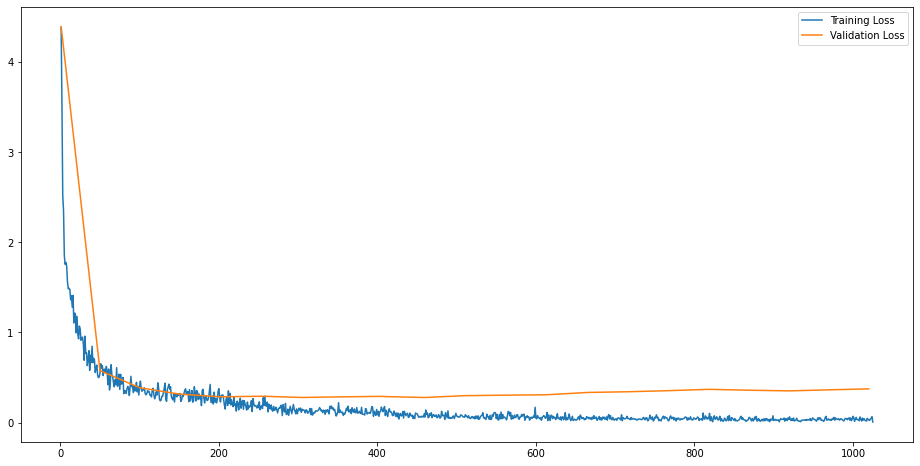

In [16]:
train_loss, train_iter, valid_loss, valid_iter = train(batch_size=64, num_epochs=5, print_every=50)

fig, ax = plt.subplots(figsize=(16,8))
plt.plot(train_iter, train_loss, label = "Training Loss")
plt.plot(valid_iter, valid_loss, label = "Validation Loss")
plt.legend()
plt.show()

### Save the model parameters

In [0]:
torch.save(slot_filling_net.state_dict(), "snips_slot_filling_model")

# Evaluation of the Trained Model

### Loading the saved model

In [18]:
slot_filling_net = SlotFillingNetwork(vocab_size, slots_size, embedding_size = 100, hidden_size = 100).to(device)
slot_filling_net.load_state_dict(torch.load('snips_slot_filling_model'))

<All keys matched successfully>

## Manual Evaluation through examples

In [0]:
def predictSlots(sentence, actual_slots):
    sent_indices = torch.tensor(indexFromSentence([sentence]), device=device)
    sent_len = torch.tensor([sent_indices.shape[1]], device=device)

    with torch.no_grad():
        hidden = slot_filling_net.initHidden(1)
        slot_predicted, hidden = slot_filling_net.forward(sent_indices, sent_len, hidden)
        topv, topi = slot_predicted.data.topk(1)
        slots_pred = []
        example_acc = 0
        for i, index in enumerate(topi.squeeze()):
            slots_pred.append(indices_to_slots[index.item()])
            if indices_to_slots[index.item()] == actual_slots.split()[i]:
                example_acc += 1
        example_acc = example_acc * 100 / sent_len
        
    return slots_pred, example_acc

def evaluateSentence(sentence, actual_slots):

    slots_pred, acc = predictSlots(sentence, actual_slots)
    df = pd.DataFrame({"Word": sentence.split(), "Predicted Slot": slots_pred, "Actual Slot": actual_slots.split()})
    print(df)
    
    print("\nAccuracy: %.2f" % (acc))

In [0]:
def loadTestData(seq_in_path, seq_out_path):
    with open(seq_in_path, "r") as file:
        input_sent = file.readlines()
    input_sent = addSentenceMarkers(input_sent)

    with open(seq_out_path, "r") as file:
        output_slots = file.readlines()
    output_slots = addSentenceMarkers(output_slots)

    df = pd.DataFrame({"sentence": input_sent, "slots": output_slots})
    return df

In [21]:
test_df = loadTestData("snips/test/seq.in", "snips/test/seq.out")
test_df.head()

,sentence,slots
0,BOS add sabrina salerno to the grime instrumen...,BOS O B-artist I-artist O O B-playlist I-playl...
1,BOS i want to bring four people to a place tha...,BOS O O O O B-party_size_number O O O O O O B-...
2,BOS put lindsey cardinale into my hillary clin...,BOS O B-artist I-artist O B-playlist_owner B-p...
3,BOS will it snow in mt on june 13 2038\n EOS,BOS O O B-condition_description O B-state O B-...
4,BOS play signe anderson chant music that is ne...,BOS O B-artist I-artist B-music_item O O O B-s...


In [0]:
def evaluateRandomly(df, num_samples = 5):
    sampled = df.sample(num_samples)
    for index, row in sampled.iterrows():
        evaluateSentence(row["sentence"], row["slots"])
        print("===============================================================\n")

In [23]:
evaluateRandomly(test_df, 5)

       Word   Predicted Slot      Actual Slot
0       BOS              BOS              BOS
1       are                O                O
2     there                O                O
3    movies     B-movie_type     B-movie_type
4        at                O                O
5     malco  B-location_name  B-location_name
6  theatres  I-location_name  I-location_name
7       EOS              EOS              EOS

Accuracy: 100.00

      Word   Predicted Slot      Actual Slot
0      BOS              BOS              BOS
1     give                O                O
2        1   B-rating_value   B-rating_value
3      out                O                O
4       of                O                O
5        6    B-best_rating    B-best_rating
6   points    B-rating_unit    B-rating_unit
7       to                O                O
8     this  B-object_select  B-object_select
9    novel    B-object_type    B-object_type
10     EOS              EOS              EOS

Accuracy: 100.00

      Wo

In [0]:
def testModel(test_df):
    tot_correct = 0
    tot_samples = 0
    for index, row in test_df.iterrows():
        slots_pred, acc = predictSlots(row["sentence"], row["slots"])
        tot_correct += acc/100.0 * len(row["sentence"].split())
        tot_samples += len(row["sentence"].split())
    
    test_acc = tot_correct/tot_samples * 100
    print("Test Accuracy: {acc:0.2f} %".format(acc=test_acc.item()))

In [25]:
testModel(test_df)

Test Accuracy: 93.28 %
